# Laplace on a sinuisoidal toy example

In [5]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

## Create training and test data

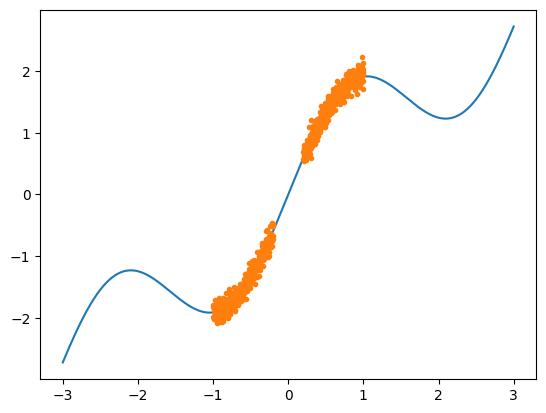

In [6]:
def f(x):
    # y = np.sin(2*x) + x + 0.3 * np.sin(50*x)
    y = np.sin(2*x) + x
    return y


N=1000
x_train = np.linspace(-1, 1, N)
x_train_all = x_train
mask = (x_train>0.2) | (x_train<-0.2)
x_train_masked = x_train[~mask]
x_train = x_train[mask]
y_train = f(x_train) + 0.1 * np.random.randn(len(x_train))

x_test = np.linspace(-3, 3, 2*N)
y_test = f(x_test)

plt.plot(x_test, y_test, '-')
plt.plot(x_train, y_train, '.')

# Define model, training and evaluation loops


In [7]:
def make_mlp(input_dim, hidden_dim, output_dim, num_layers):

    layers = []
    layers.append(nn.Linear(input_dim, hidden_dim))
    layers.append(nn.Tanh())
    for _ in range(num_layers-2):
        layers.append(nn.Linear(hidden_dim, hidden_dim, bias=True))
        layers.append(nn.Tanh())
    layers.append(nn.Linear(hidden_dim, output_dim, bias=True))

    return nn.Sequential(*layers)

def train_model(model, epochs, x, y, device):

    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    x, y = x.to(device), y.to(device)
    
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)

    loss_history = []
    for i in range(epochs):
        
        optimizer.zero_grad()

        pred = model(x)
        loss = torch.mean(torch.mean((pred - y) ** 2, dim=-1))
        loss.backward()
        optimizer.step()

        if i % 500 == 0:
            print(f'Epoch {i}, loss {loss.item()}')

        loss_history.append(loss.item())

    return {"loss_history" : loss_history}

def test_model(model, x_test, device):

    model.eval()
    x = torch.tensor(x_test, dtype=torch.float32)
    x = x.to(device).reshape(-1, 1)

    with torch.no_grad():
        pred = model(x)

    return {"pred" : pred}


# Train model

Epoch 0, loss 2.2900896072387695
Epoch 500, loss 0.009905298240482807
Epoch 1000, loss 0.009887989610433578
Epoch 1500, loss 0.009884141385555267
Epoch 2000, loss 0.009879425168037415
Epoch 2500, loss 0.00987272709608078
Epoch 3000, loss 0.009862953796982765
Epoch 3500, loss 0.009848061949014664
Epoch 4000, loss 0.009824558161199093
Epoch 4500, loss 0.009788645431399345


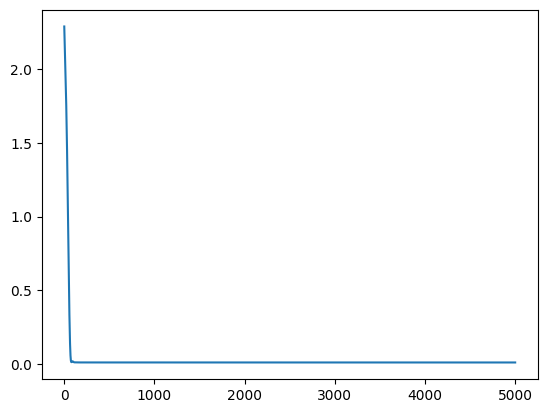

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = make_mlp(1, 16, 1, 4)
model = model.to(device)

out = train_model(model, 5000, x_train, y_train, device)

plt.plot(out["loss_history"])
plt.show()

# Show model fit

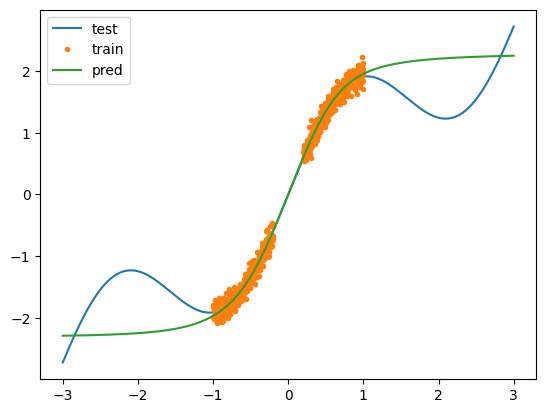

In [9]:
out = test_model(model, x_test, device)


plt.plot(x_test, y_test, '-', label="test")
plt.plot(x_train, y_train, '.', label="train")
plt.plot(x_test, out["pred"].cpu().numpy(), label="pred")
plt.legend()
plt.show()

# Perform Laplace Approximation on the model

In [10]:
from nnj.utils import convert_to_nnj
from pytorch_laplace import MSEHessianCalculator
from pytorch_laplace.laplace.diag import DiagLaplace
from pytorch_laplace.optimization.prior_precision import optimize_prior_precision
from torch.nn.utils import parameters_to_vector, vector_to_parameters

In [11]:
def fit_hessian(model, x, batch_size=1024):

    model.eval()

    hessian_calculator = MSEHessianCalculator(
        wrt="weight",
        shape="diagonal",
        speed="half",
    )

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    hessian = torch.zeros_like(parameters_to_vector(model.parameters()), device=device)
    for i in range(0, x.shape[0], batch_size):
        with torch.no_grad():
            model(x[i:i+batch_size])
            
            h = hessian_calculator.compute_hessian(x[i:i+batch_size], model)
            hessian += h * batch_size

        if i % 100 == 0:
            print(f"{i}, {hessian.max()} {hessian.min()}")

    return hessian

def sample_laplace(model, hessian, alpha, prior_prec, x, n_samples=1000):

    laplace = DiagLaplace()

    # get mean and std of posterior
    mu_q = parameters_to_vector(model.parameters()).unsqueeze(1)
    sigma_q = laplace.posterior_scale(hessian, prior_prec=prior_prec, scale=alpha)

    # draw samples
    nn_weight_samples = laplace.sample(mu_q, sigma_q, n_samples)

    # forward n times
    preds = []
    for i in range(n_samples):
        with torch.no_grad():
            # use sample i that was generated in beginning of evaluation
            net_sample = nn_weight_samples[i]

            # replace the network parameters with the sampled parameters
            vector_to_parameters(net_sample, model.parameters())
            
            pred = model(x)

            preds.append(pred)

    preds = torch.stack(preds)

    # compute statistics
    pred_mu = preds.mean(dim=0)
    pred_sigma = preds.std(dim=0)
    
    # put mean parameters back
    vector_to_parameters(mu_q, model.parameters())

    return pred_mu, pred_sigma

# Convert to nnj and fit hessian

In [12]:
nnj_model = convert_to_nnj(model)
nnj_model.eval()

model_input = torch.from_numpy(x_train_all.reshape(-1,1)).type(torch.float32).to(device)
hessian = fit_hessian(nnj_model, model_input, batch_size=1024)

0, 1024.0 0.05528251826763153


# Visualize Laplace predictions

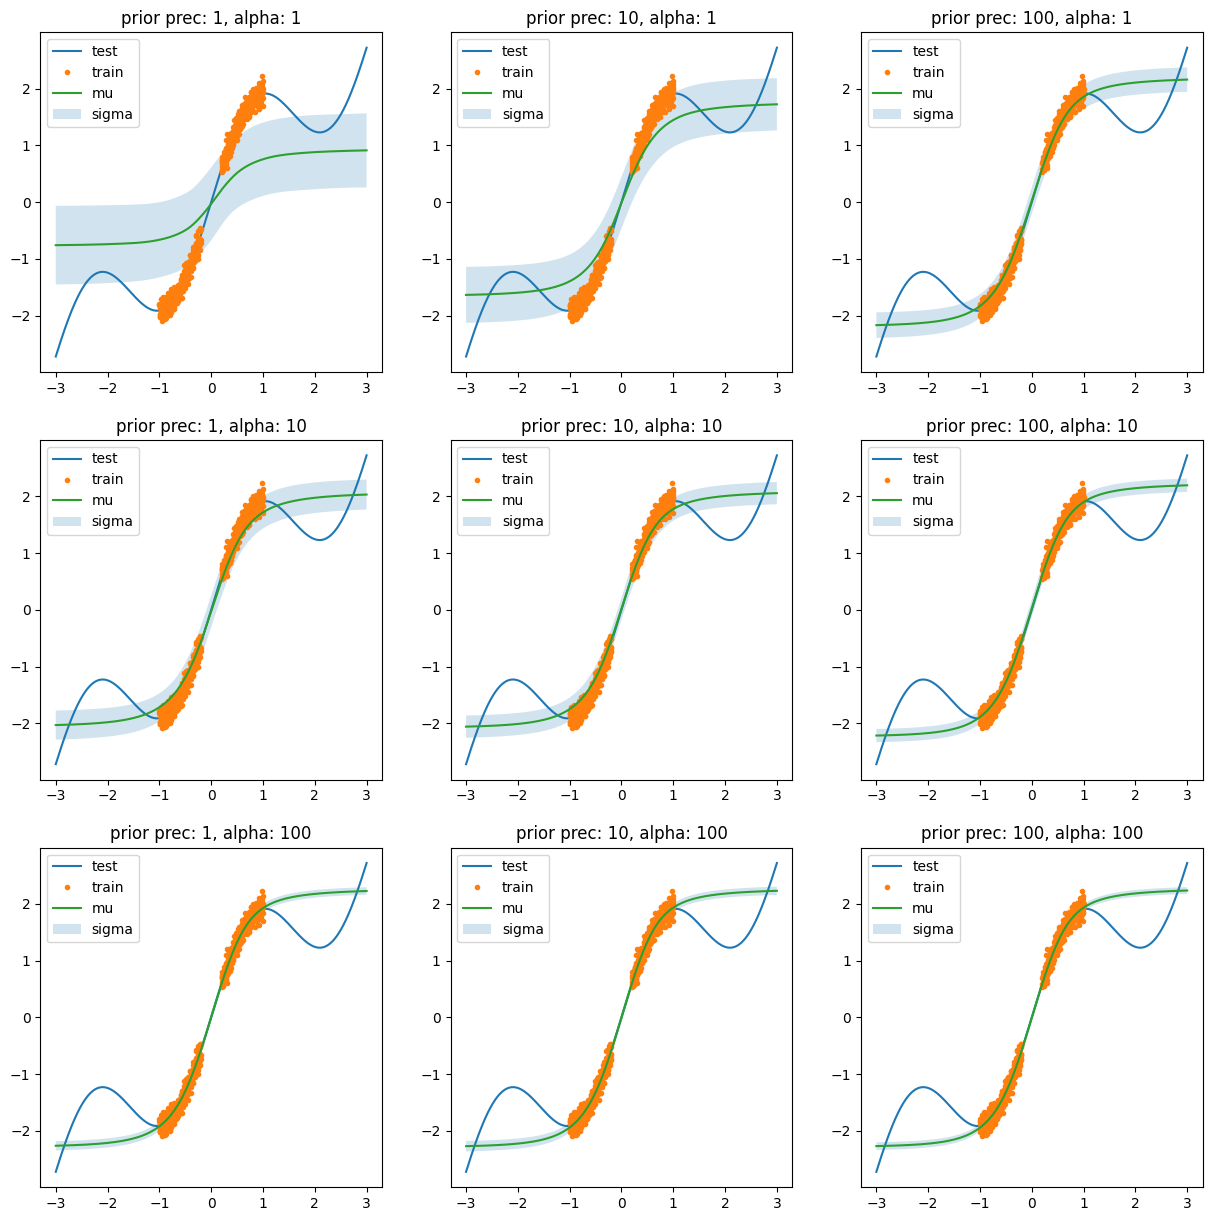

In [13]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
for j, alpha in enumerate([1, 10, 100]):
    for i, prior_prec in enumerate([1, 10, 100]):

        model_input = torch.from_numpy(x_test.reshape(-1,1)).type(torch.float32).to(device)
        mu, sigma = sample_laplace(nnj_model, hessian, alpha=alpha, prior_prec=prior_prec, x=model_input, n_samples=100)

        mu = mu.cpu().numpy().reshape(-1)
        sigma = sigma.cpu().numpy().reshape(-1)

        ax[j, i].plot(x_test, y_test, '-', label="test")
        ax[j, i].plot(x_train, y_train, '.', label="train")
        ax[j, i].plot(x_test, mu, label="mu")
        ax[j, i].fill_between(x_test, mu - sigma, mu + sigma, alpha=0.2, label="sigma")
        ax[j, i].legend()
        ax[j, i].set_title(f"prior prec: {prior_prec}, alpha: {alpha}")
plt.show()

# Visualize Linearized Laplace predictions